In [3]:
%matplotlib inline

from numpy import sqrt, log, tanh 
from clawpack import riemann
from clawpack import pyclaw

# Travelling wave solution
def travel(x,t,ul,ur,nu): return (ur+ul)/2-abs((ul-ur))/2*tanh((x-(ur+ul)/2*t)*(ul-ur)/4/nu ) 

def qtrue(x,t,ul,ur,nu):
    """
    The true solution, for comparison.  
    """
    import numpy as np
    dim = x.shape[0] 
    q = np.empty(dim)
    
    for i in range(dim):
            q[i] = travel(x[i],t,ul,ur,nu)
    return q


def burgers(q_l,q_r,aux_l,aux_r,problem_data):
    r"""
    1d burgers riemann solver 
    """
    import numpy as np
    num_eqn = 1
    num_waves = 1

    # Convenience
    num_rp = q_l.shape[1]

    # Return values
    wave = np.empty( (num_eqn, num_waves, num_rp) )
    s = np.empty( (num_waves, num_rp) )
    amdq = np.empty( (num_eqn, num_rp) )
    apdq = np.empty( (num_eqn, num_rp) )

    # Local values
    delta = np.empty(np.shape(q_l))

    delta = q_r - q_l
    
    
    # Compute the wave
    # 1-Wave
    wave[0,0,:] = delta 
    s[0,:] = 0.5 * (q_r[0,:] + q_l[0,:])
    
    # Compute the left going and right going fluctuations
    s_index = np.zeros((2,num_rp))
    s_index[0,:] = s[0,:]
    amdq[0,:] = np.min(s_index,axis=0) * wave[0,0,:]
    apdq[0,:] = np.max(s_index,axis=0) * wave[0,0,:]
        
    # Compute entropy fix
    if problem_data['efix']:
        transonic = (q_l[0,:] < 0.0) * (q_r[0,:] > 0.0)
        amdq[0,transonic] = -0.5 * q_l[0,transonic]**2
        apdq[0,transonic] = 0.5 * q_r[0,transonic]**2

    return wave, s, amdq, apdq

def source_term(solver, state, dt):
    from scipy.linalg import solve_banded
    import numpy as np
    qs = state.q[0,:]
    xc = state.grid.c_centers[0]
    nx = xc.size
    dx = (xc[-1]-xc[0])/nx
    nu = state.problem_data['nu']
    r = nu*dt/(dx**2*2.)
    m = qs.shape[0]
    b = np.empty(m)
    for i in range(m):
        if i == 0:
            b[0] = (1-r)*qs[0]+r*qs[1]
        elif i == m-1:
            b[m-1] = (1-r)*qs[m-1]+ r*qs[m-2]
        else:
            b[i] = r*qs[i-1]+(1-2*r)*qs[i]+r*qs[i+1]
    
    ab = np.empty((3,m))
    ab[0,1:] = [-r]*(m-1)
    ab[1,:] = [1+2*r]*m
    ab[2,:-1] = [-r]*(m-1)
    ab[1,0] = 1+r
    ab[1,-1]=1+r
    state.q[0,:] = solve_banded((1,1),ab,b)
     

def setup(outdir='./_output',  output_style=1):
    
    solver = pyclaw.ClawSolver1D()
    
    #solver.rp = riemann.burgers_1D_py.burgers_1D
    #solver = pyclaw.SharpClawSolver1D()
    solver.rp = burgers
    #solver.weno_order = 5
    #solver.lim_type = 2
    #solver.time_integrator = 'SSP33'
    #solver.cfl_max = 0.5

    solver.num_waves = 1
    solver.num_eqn = 1
    solver.kernel_language = 'Python'
    solver.limiters = pyclaw.limiters.tvd.superbee
    solver.bc_lower[0] = pyclaw.BC.extrap
    solver.bc_upper[0] = pyclaw.BC.extrap
    solver.order = 2 #1: Godunov, 2: Lax-Wendroff-LeVeque
    
    solver.step_source = source_term
    
    mx = 600
    x = pyclaw.Dimension(-3, 3, mx, name='x')
    domain = pyclaw.Domain(x)
    num_eqn = 1
    
    state = pyclaw.State(domain, num_eqn)
    
    nu = 0.5 
    ul = 2
    ur = 0
    state.problem_data['efix'] = True
    state.problem_data['nu'] = nu #diffusivity
    state.problem_data['ul'] = ul #left state
    state.problem_data['ur'] = ur #right state
    
    xc = domain.grid.x.centers
    
    
    #for i in range(mx):
            #state.q[0,i] = travel(xc[i],0,ul,ur,nu)   #initial condition
            
    state.q[0,:] = travel(xc,0,ul,ur,nu)
    
    claw = pyclaw.Controller()
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.outdir = outdir
    claw.output_style = output_style
    claw.tfinal = 2.0
    claw.num_output_times = 20
    claw.keep_copy = True
    #claw.setplot = setplot

    return claw


def setplot(plotdata):
    """ 
    Plot solution using VisClaw.
    """ 
    plotdata.clearfigures()  # clear any old figures,axes,items data

    plotfigure = plotdata.new_plotfigure(name='q', figno=1)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.ylimits = [-.2,1.0]
    plotaxes.title = 'q'

    # Set up for item on these axes:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 0
    plotitem.plotstyle = '-o'
    plotitem.color = 'b'
    plotitem.kwargs = {'linewidth':2,'markersize':5}
    
    return plotdata


2024-04-01 19:34:29,121 INFO CLAW: Solution 0 computed for time t=0.000000


2024-04-01 19:34:29,394 INFO CLAW: Solution 1 computed for time t=0.100000
2024-04-01 19:34:29,417 INFO CLAW: Solution 2 computed for time t=0.200000
2024-04-01 19:34:29,441 INFO CLAW: Solution 3 computed for time t=0.300000
2024-04-01 19:34:29,466 INFO CLAW: Solution 4 computed for time t=0.400000
2024-04-01 19:34:29,491 INFO CLAW: Solution 5 computed for time t=0.500000
2024-04-01 19:34:29,513 INFO CLAW: Solution 6 computed for time t=0.600000
2024-04-01 19:34:29,535 INFO CLAW: Solution 7 computed for time t=0.700000
2024-04-01 19:34:29,558 INFO CLAW: Solution 8 computed for time t=0.800000
2024-04-01 19:34:29,581 INFO CLAW: Solution 9 computed for time t=0.900000
2024-04-01 19:34:29,606 INFO CLAW: Solution 10 computed for time t=1.000000
2024-04-01 19:34:29,630 INFO CLAW: Solution 11 computed for time t=1.100000
2024-04-01 19:34:29,655 INFO CLAW: Solution 12 computed for time t=1.200000
2024-04-01 19:34:29,681 INFO CLAW: Solution 13 computed for time t=1.300000
2024-04-01 19:34:29,7

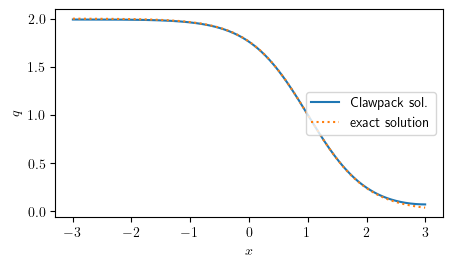

In [4]:
claw = setup()
claw.run()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
index = 10
frame = claw.frames[index]
dt = claw.tfinal/claw.num_output_times
t = dt*index
x = frame.state.grid.c_centers
x = x[0]

ul = frame.state.problem_data['ul']
ur = frame.state.problem_data['ur']
nu = frame.state.problem_data['nu']
true = qtrue(x,t,ul,ur,nu)
fig, ax = plt.subplots(figsize=(5, 2.7))
w = frame.q[0,:]

ax.plot(x, w, label='Clawpack sol.')
ax.plot(x, true, ':',label='exact solution')
ax.legend(loc='right')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$q$')
plt.savefig("ViscousBurgerClaw.pdf",bbox_inches='tight')

In [5]:
nsimul=np.size(claw.frames)
figs = []
for i in range(nsimul):
    fig, ax = plt.subplots(figsize=(5, 3))
     
        
    frame = claw.frames[i]
    w = frame.q[0,:]
    x = frame.state.grid.c_centers
    x = x[0]
    dt = claw.tfinal/claw.num_output_times
    t = dt*i
    true = qtrue(x,t,ul,ur,nu)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$q$')
    plt.plot(x, w)
    plt.plot(x, true, '--',color = 'r')
    figs.append(fig)
    plt.close(fig)
    
from clawpack.visclaw import animation_tools
animation_tools.interact_animate_figs(figs)    

interactive(children=(IntSlider(value=0, description='frameno', max=20), Output()), _dom_classes=('widget-inte…

In [6]:
 

def q_true(t,ul,ur,nu):
    import numpy
    # True Solution
    x_true = numpy.linspace(-3.0, 3.0, 1000)
    q_true = travel(x_true,t,ul,ur,nu)
    return q_true

def burgers_animation(ul=2, ur=0, nu=0.5):
    import matplotlib.animation
    import numpy
    # compute the solution with the method define above:
    claw = setup()
    claw.keep_copy = True
    claw.run()
    x = claw.frames[0].grid.dimensions[0].centers
    x_true = numpy.linspace(-3.0, 3.0, 1000)
    
    fig = plt.figure()
    axes = plt.subplot(1, 1, 1)
    axes.set_xlim((x[0], x[-1]))
    axes.set_ylim((-0.1, 2))
    axes.set_title("Viscous burgers equation")
    
    def init():
        axes.set_xlim((x[0], x[-1]))
        axes.set_ylim((-0.1,2.1))
        computed_line, = axes.plot(x[0], claw.frames[0].q[0, :][0], 'ro')
        exact_line, = axes.plot(x_true[0], q_true(0.0,ul,ur,nu)[0], 'k')
        return (computed_line, exact_line)
    
    computed_line, exact_line = init()
    
    def fplot(n):
        computed_line.set_data([x,], [claw.frames[n].q[0, :]])
        exact_line.set_data([x_true], [q_true(claw.frames[n].t,ul,ur,nu)])
        return (computed_line, exact_line)

    frames_to_plot = range(0, len(claw.frames))
    plt.close(fig)
    return matplotlib.animation.FuncAnimation(fig, fplot, frames=frames_to_plot, interval=100,
                                   blit=True, init_func=init, repeat=False)

In [7]:
from IPython.display import HTML 
anim = burgers_animation()
HTML(anim.to_jshtml())

2024-04-01 19:34:35,647 INFO CLAW: Solution 0 computed for time t=0.000000
2024-04-01 19:34:35,672 INFO CLAW: Solution 1 computed for time t=0.100000
2024-04-01 19:34:35,701 INFO CLAW: Solution 2 computed for time t=0.200000
2024-04-01 19:34:35,751 INFO CLAW: Solution 3 computed for time t=0.300000
2024-04-01 19:34:35,805 INFO CLAW: Solution 4 computed for time t=0.400000
2024-04-01 19:34:35,835 INFO CLAW: Solution 5 computed for time t=0.500000
2024-04-01 19:34:35,862 INFO CLAW: Solution 6 computed for time t=0.600000
2024-04-01 19:34:35,892 INFO CLAW: Solution 7 computed for time t=0.700000
2024-04-01 19:34:35,916 INFO CLAW: Solution 8 computed for time t=0.800000
2024-04-01 19:34:35,937 INFO CLAW: Solution 9 computed for time t=0.900000
2024-04-01 19:34:35,963 INFO CLAW: Solution 10 computed for time t=1.000000
2024-04-01 19:34:35,985 INFO CLAW: Solution 11 computed for time t=1.100000
2024-04-01 19:34:36,005 INFO CLAW: Solution 12 computed for time t=1.200000
2024-04-01 19:34:36,02

In [8]:
# Export as mp4
anim.save('ViscousBurgers.mp4',fps=5,writer="ffmpeg",dpi=300) 

2024-04-01 19:34:43,849 INFO CLAW: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2024-04-01 19:34:43,850 INFO CLAW: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1920x1440 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ViscousBurgers.mp4


In [7]:
# Export as png
anim.save('ViscousBurgers.png', writer="imagemagick",dpi=300) 

2024-01-08 12:20:37,743 INFO CLAW: Animation.save using <class 'matplotlib.animation.ImageMagickWriter'>
2024-01-08 12:20:37,744 INFO CLAW: MovieWriter._run: running command: convert -size 1920x1440 -depth 8 -delay 10.0 -loop 0 rgba:- -layers OptimizePlus ViscousBurgers.png


In [19]:
# Export as png (alternative)
for i in range(len(figs)):
    figs[i].savefig('ViscousBurgersFrame'+str(i)+'.png', bbox_inches='tight',dpi=300)